# Support Vector Machines


<h2>Introduction</h2>
There are two parts to this lab session. 

1. A part on PEGASOS where you are asked to implement the stochastic version of PEGASOS

2. A part on features mapping

Data are 2D. You can visualize them by running the following cell (red dots are labeled -1 and green dots are labeled 1).

data/dataset1.txt


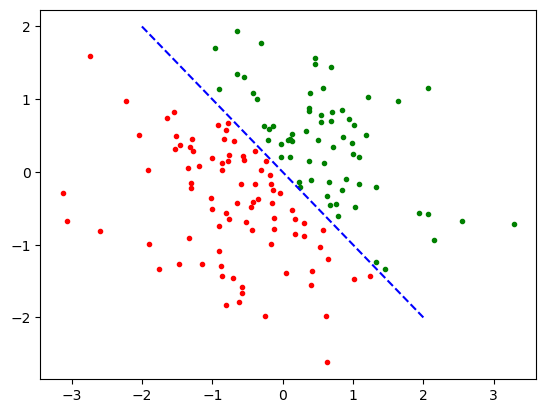

data/dataset2.txt


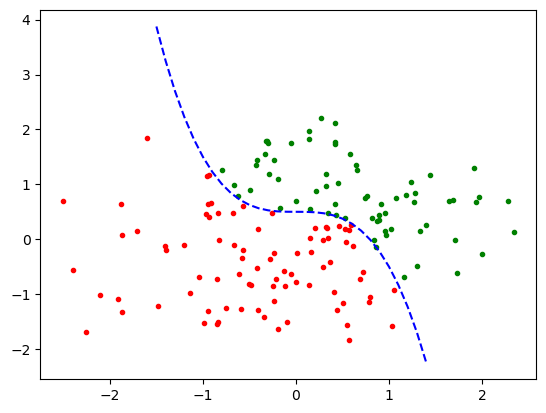

data/dataset3.txt


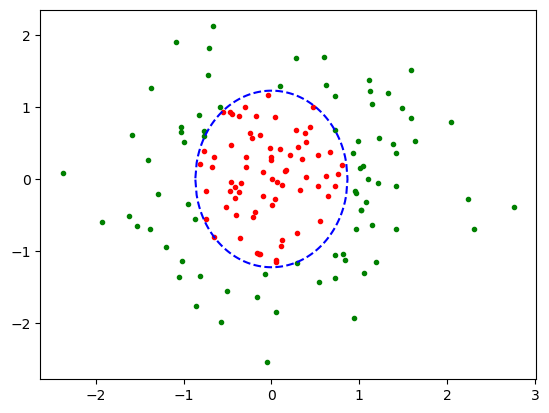

data/dataset4.txt


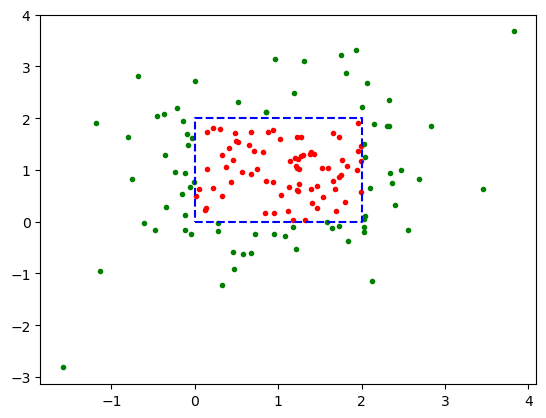

In [43]:
import numpy as np                                              
import matplotlib.pyplot as plt
import random
from math import sqrt, cos, pi
import pandas as pd

# print the datasets and their delimiters
datasets = ["data/dataset" + str(x) + ".txt" for x in range(1, 5)]
for dataset in datasets :
    print(dataset)
    points_df=pd.read_csv(dataset,delimiter=' ')
    plt.plot(points_df.x_1[points_df.y==-1],points_df.x_2[points_df.y==-1],'r.') # points whose target y is -1
    plt.plot(points_df.x_1[points_df.y==1],points_df.x_2[points_df.y==1],'g.') # points whose target y is +1
    # draw exact delimiter
    if dataset == datasets[0]:
        plt.plot(np.array([0,40])/10-2,-np.array([0,40])/10+2, 'b--')
    elif dataset == datasets[1]:
        plt.plot([x/10-1.5 for x in range(30)], [0.5-((x/10)-1.5)**3 for x in range(30)], 'b--')
    elif dataset == datasets[2]:
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [-np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
    elif dataset == datasets[3]:
        plt.plot([x/8 for x in range(17)] + [2 for x in range(17)] + [(2-x/8) for x in range(17)] + [0 for x in range(17)],
             [0 for y in range(17)] + [y/8 for y in range(17)] + [2 for y in range(17)] + [(2-y/8) for y in range(17)], 'b--')
    plt.show()
    

### Question 0.1
According to the above plots, do these datasets seem to be linearly separable? On which of these datasets do you expect a linear SVM to perform well? On which ones do you think it will perform badly?

Your answer here:

- Only dataset1.txt is linearly separable.
- A linear SVM will perform well on dataset1.txt, and quite well on dataset2.txt.
- A linear SVM will perform badly on dataset3.txt and dataset4.txt (since they are not linearly separable), unless we use specific kernels in order to make the dataset linearly separable in a higher dimensional feature space. 


<h2>Part 1: PEGASOS</h2>

<h3>How PEGASOS works</h3>

<i>That sub-part gives some intuition about how PEGASOS can actually find the solution of a problem cast by a linear SVM. Reading it is not required to do the lab, but we encourage you to have a look at it as it may help you for your implementation.</i>

Let us assume that given a set $S = \lbrace (x_i, y_i) \rbrace$ where $x_i \in \mathbb{R}^n$ and $y_i \in \lbrace -1, 1 \rbrace$, we want to find a solution of the following problem

$$\min_{w, b} \frac{1}{2} \Vert w \Vert^2 + C \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $C$ is a non-zero hyperparameter controlling the "softness" of the margin (the lower the $C$ the softer the margin), or equivalently

$$\min_{w, b} \frac{\lambda}{2} \Vert w \Vert^2 + \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $\lambda$ replaces $C$ (the higher the $\lambda$ the softer the margin). We can get rid of the bias term $b$ by adding a constant feature to all the $x_i$ (we can assume without loss of generality that the value of the constant is 1) and by replacing $w$ by the concatenation of $w$ and $b$. In that setup, the optimization problem becomes (with $\tilde{w} = [w; b]$ and $\tilde{x_i} = [x_i; 1]$)

$$\min_{\tilde{w}} \frac{\lambda}{2} \Vert \tilde{w} \Vert^2 + \sum_i \max(0, 1-y_i(\tilde{w}^T\tilde{x_i})).$$

You can notice that the optimization problem we obtained is slightly different from the one we stated before, as $\Vert \tilde{w} \Vert^2$ should be replaced by $\Vert \tilde{w} \Vert^2 - b^2$. However, in practice, that difference has very few importance. Therefore in the following we will assume that $x_i \in \mathbb{R}^{n+1}$, $w \in \mathbb{R}^{n+1}$, and that the last feature of $x_i$ is always equal to 1. As we will work on the stochastic variant of PEGASOS, we will consider the following objective:

$$\min_{w_t} \frac{\lambda}{2} \Vert w_t \Vert^2 + \max(0, 1-y_{i_t}(w_t^Tx_{i_t}))$$

where $(x_{i_t}, y_{i_t})$ is a sample drawn randomly at iteration $t$ from $S$. The sub-gradient of the above objective is then given by:

$$\nabla w_t = \lambda w_t - \phi_I(x_{i_t}, y_{i_t}) y_{i_t}x_{i_t}$$

where $\phi_I$ is the indicator function of the set $I = \lbrace (x, y) \in R^d \times \lbrace -1, 1 \rbrace : y w^Tx < 1 \rbrace$ ($\phi_I(x, y) = 1$ if $(x, y) \in I$ and $\phi_I(x, y) = 0$ otherwise). Then, we compute $w_{t+1}$ using the following update formula:

$$w_{t+1} = w_t - \eta_t \nabla w_t$$

where $\eta_t = 1/(\lambda t)$. The algorithm stops after a predefined number of iterations. As you can understand, PEGASOS uses a stochastic gradient descent with learning rate $\eta_t$ to find the optimal parameters of an SVM. The next sub-part gives you a pseudo-code of PEGASOS. Your role will be to implement it based on that pseudo-code.

<h3>Pseudo-code of PEGASOS</h3>

Your task will now be to implement PEGASOS. An SVM class has been defined in utils.py. You are strongly encouraged to read it carefully to understand it.

### Exercise 1.1
Complete the following implementation of PEGASOS.

In [44]:
from utils import SVM, Dataset

def train(self, n_iterations, lambda_w, print_every_k=None,verbose=False):
    '''
    Train function for an SVM model using PEGASOS.
    If verbose is TRUE print the accuracy every 'print_every_k' iterations

    INPUTS:
    - self containing in particular:
        self.train_dataset with inside
            self.train_dataset.input -> inputs in a numpy NxD array, N number of sample, D dimensions
            self.train_dataset.output -> outputs in a numpy X array
        self.w -> weights of the model initialized at random before. Length D+1, because 1 is the bias
    - n_iterations -> total number of epochs
    - lambda_w -> lambda in PEGASOS
    - print_every_k -> compute the accuracy of the model every 'print_every_k' epochs
    - verbose -> if TRUE, in addition of computing the accuracy, the model also print it every 'print_every_k' epochs
    '''

    
    if not print_every_k:
        print_every_k = max(1, int(n_iterations/50))
        self.print_step=print_every_k
    # self.w = np.zeros(self.w.size)
    # For n_iterations epochs
    for i in range(n_iterations): # equivalent for t in {1,...,T}
    
    # ! REMEMBER TO UPDATE self.w AT THE END OF EVERY ITERATION
    # ! self.train_dataset.input DOES NOT CONTAIN THE BIAS : a '1' in the dimension D+1
        # REMBER TO ADD THE '1' OF THE BIAS TO YOUR x VECTOR OR YOU WILL HAVE A SIZE MISMATCH
        # ADD THE BIAS IN THE LAST POSITION OF YOUR x VECTOR, OTHERWISE THE REST OF THE TRAIN WILL BE WRONG
        # x VECTOR OF [self.train_dataset.input[sample,:], 1]
    
    ################ YOUR CODE HERE #################
        sample = random.randint(0, self.train_dataset.input.shape[0]-1)
        x = np.append(self.train_dataset.input[sample,:], 1)
        y = self.train_dataset.output[sample]
        eta = 1/(lambda_w*(i+1))
        prediction = np.dot(self.w, x)
        if y*prediction < 1:
            self.w = self.w - eta*(lambda_w*self.w - y*x)
        else:
            self.w = self.w - eta*lambda_w*self.w
    ################ END OF YOUR CODE ###############
    
        if not i%print_every_k:
            if verbose:
                print("Epoch: ", i+1, " out of ", n_iterations)
                self.print_accuracy()
            else:
                self.compute_accuracy()
                    
SVM.train = train                    

### Question Exercise 1.2
Test your implementation on the four datasets (train your SVM during 1500 iterations with $\lambda = 0.0001$).
You have to:

1. create 2 objects Dataset, with the train dataset and test dataset for each dataset in the folder data
2. initialize your SVM model with the 2 objects
3. use the train function of your SVM object to train it
4. use the make_plot function of your SVM object to make the plot of its accuracy
5. use the function print_accuracy of your SVM object to see the final training accuracy

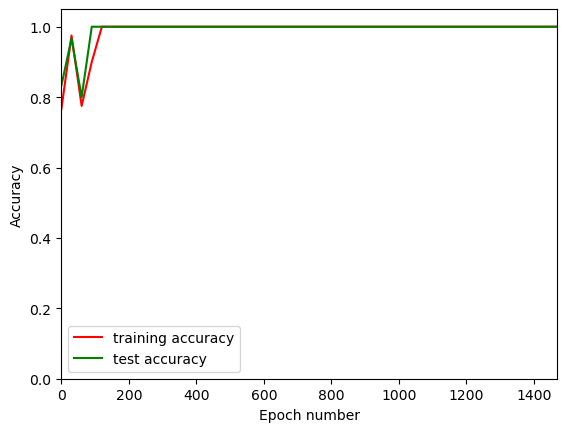

Accuracy: 100.0 %


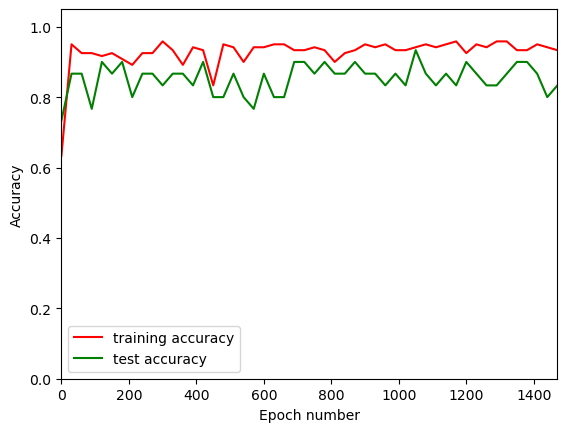

Accuracy: 94.16666666666667 %


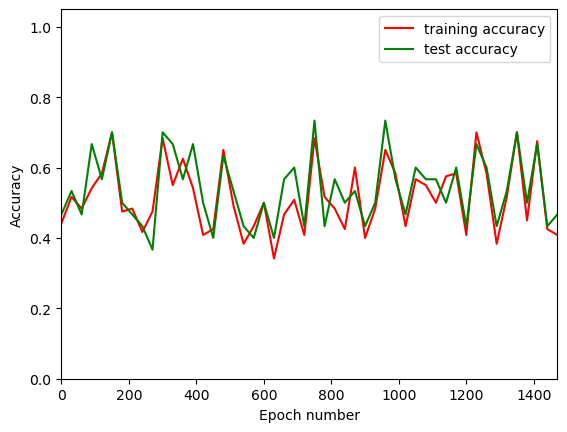

Accuracy: 45.83333333333333 %


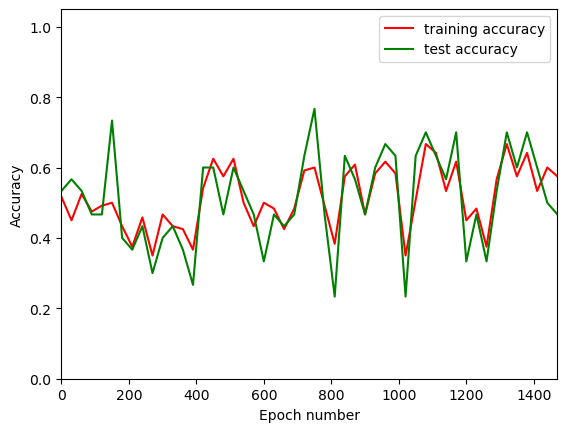

Accuracy: 61.66666666666667 %


In [45]:
# Create the datasets
for i in range(1, 5):
    train = Dataset("data/dataset" + str(i) + "_train.txt")
    test = Dataset("data/dataset" + str(i) + "_test.txt")
    svm = SVM(train, test)
    svm.train(1500, 0.0001)
    svm.make_plot()
    svm.print_accuracy()

### Question 1.1
Do you find the results that you forecast in Question 0.1?

- Yes, on the first dataset we get high accuracy (linearly separable).
- On the second dataset we get a slightly lower accuracy (the data are not linearly separable, but still have a good shape for a linear classifier).
- On the last two datasets, we can see that we don't get great results, since data is not linearly separable, and the shape of the data is not good for a linear classifier.

<h2>Part 2: Features Maps</h2>

As you know, it is possible to use the "Kernel Trick" to separate non-linearly separable datasets with SVMs. This trick is meant to be applied on the dual problem. As PEGASOS is based on the primal problem, the Kernel Trick cannot be used easily with PEGASOS. However, there is a method to approximate the feature space corresponding to a given kernel. In this part, you will implement and test that method. You will not be asked to dig into the mathematical theory behind that method, but if you wish, you can find more informations in the paper <i>Random Features for Large-Scale Kernel Machines</i> by Ali Rahimi and Ben Recht [1].

### Approximating the Radial Basis Function (RBF) kernel

The Radial Basis Function $K_\gamma$ is one of the most common kernels used with SVMs. It is defined as follows ($x, y \in \mathbb{R}^d$):

$$ K_\gamma(x, y) = \exp(-\gamma \Vert x - y \Vert^2).$$

Its feature space is of infinite dimension. However, you can approximate it according to the following algorithm (details in [1]):

The pseudo-code above transforms data from its original space to a new feature space approximating the feature space corresponding to the RBF kernel. You will now implement that pseudo-code.

#### Exercise 2.1
Complete the following implementation of the FeaturesMap class.

In [46]:
import numpy as np
from utils import Dataset
from math import cos, pi
import random

class FeaturesMap:

    def __init__(self, D, d, gamma):
        '''
        INPUT:
        - d : old dimensions
        - D : new dimensions
        - gamma : softness/hardness parameter
        '''
        mean = np.zeros(d)
        cov = 2*d*gamma*np.eye(d)
        self.D = D
        self.w = np.array([np.random.multivariate_normal(mean, cov) for _ in range(D)])
        self.b = np.array([random.random()*2*pi for _ in range(D)])

    def __call__(self, dataset):
        outputs = dataset.output
        S_prime = [] # S'
        S=dataset.input
        for x in S:
            # compute z and append the values to S_prime keeping it as a list if you want
            ########## YOUR CODE HERE #################
            z = np.array([cos(np.dot(self.w[i], x) + self.b[i]) for i in range(self.D)])
            z = z*sqrt(2/self.D)
            S_prime.append(z)
            ########## END OF YOUR CODE HERE ##########
            
        new_data = Dataset(input_size=self.D, length=dataset.len)
        new_data.input = np.array(S_prime)
        new_data.output = outputs
        
        return new_data

#### Exercise 2.2
Test your implementation on the four artificial datasets. Train your SVM during 1500 iterations with $\lambda = 0.0001$. The dimension of the feature space is 200 and $\gamma = 1$.

1. Create Dataset() objects for each train and test dataset
2. Move each train and test Dataset() object using FeaturesMap()
3. Init and train SVM with featured map model



Dataset 1


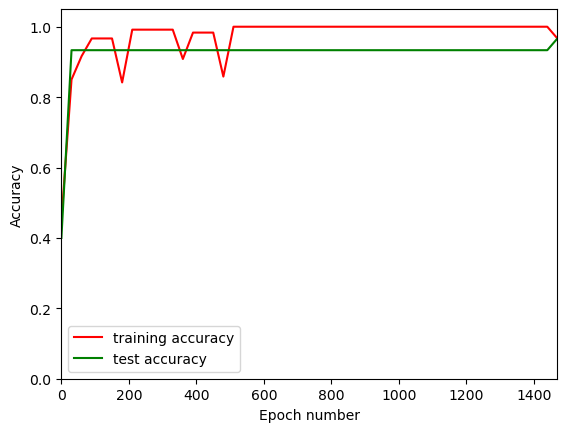

Accuracy: 96.66666666666667 %


Dataset 2


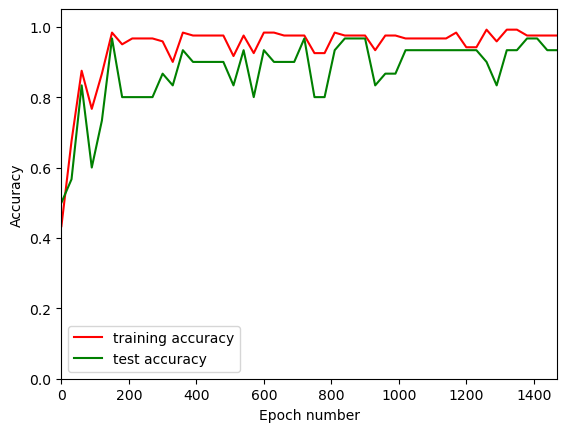

Accuracy: 97.5 %


Dataset 3


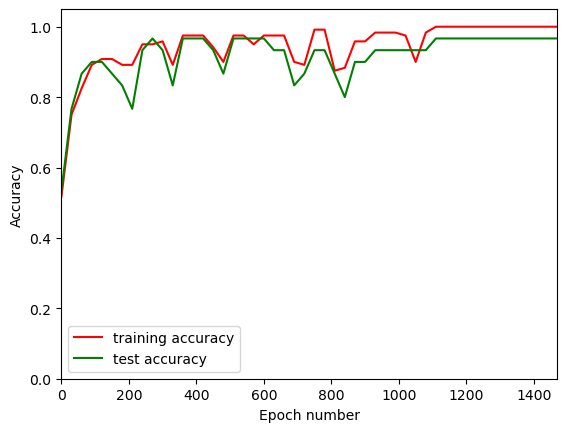

Accuracy: 100.0 %


Dataset 4


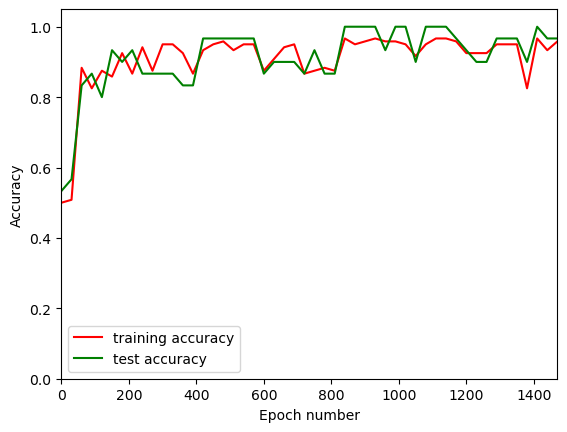

Accuracy: 94.16666666666667 %


In [47]:
n_iterations=1500
lambda_w = 0.0001
D=200
gamma=1

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    svm = SVM(new_train_data, new_test_data)
    svm.train(1500, 0.0001)
    svm.make_plot()
    svm.print_accuracy()
    ########## END YOUR CODE ############ 


#### Question 2.1 
How do your results change with respect to what you found in Question 1.1?

We can see that now we get very high accuracies on all the datasets. This is due to the fact that we are now able to separate the data in a higher dimensional space (feature space corresponding to the RBF kernel), where they are linearly separable.

### The role of $\gamma$ in the RBF kernel

#### Exercise 2.3
Do the same tests with $\gamma = 10^{-6}$. What do you notice? How can you explain your results?



Dataset 1


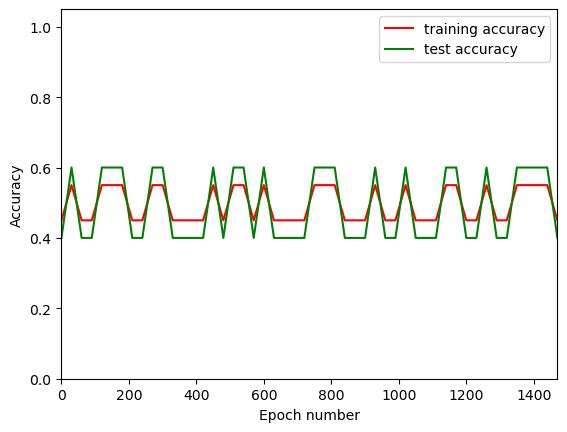

Accuracy: 45.0 %


Dataset 2


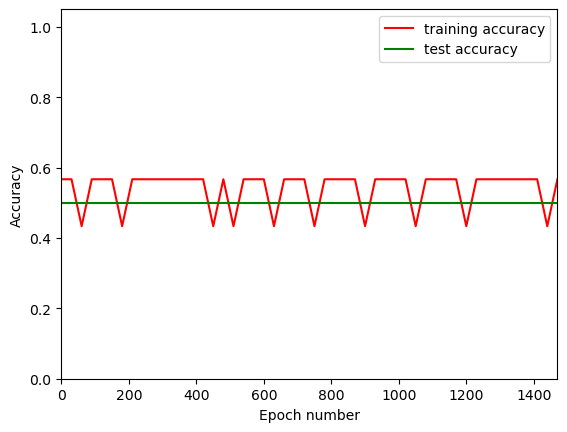

Accuracy: 43.333333333333336 %


Dataset 3


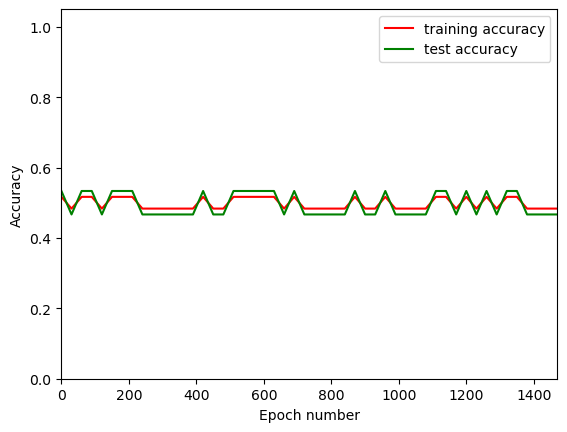

Accuracy: 51.66666666666667 %


Dataset 4


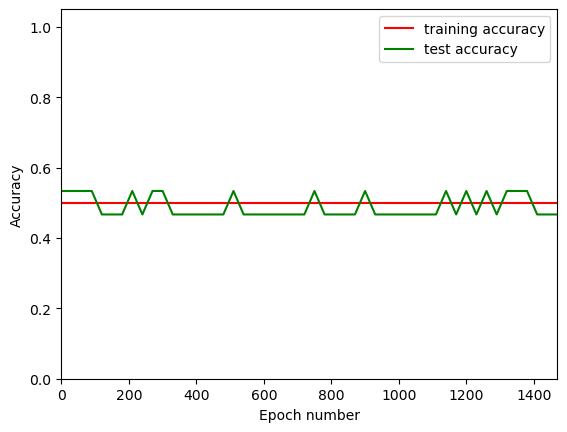

Accuracy: 50.0 %


In [48]:
n_iterations=1500
lambda_w = 0.0001
D=200
gamma=0.000001

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    svm = SVM(new_train_data, new_test_data)
    svm.train(1500, 0.0001)
    svm.make_plot()
    svm.print_accuracy()
    ########## END YOUR CODE ############ 

#### Answer 2.3
When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data, since the region of influence of any selected support vector would include the whole training set. This, as we can see from the plots, leads to underfitting.

#### Exercise 2.4
Do the same tests with $\gamma = 10^{4}$. What do you notice? How can you explain your results?



Dataset 1


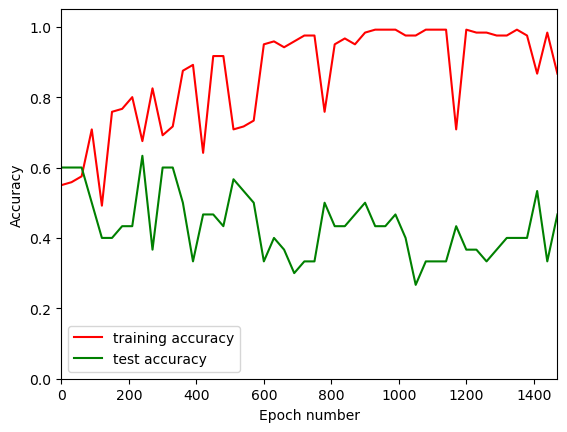

Accuracy: 99.16666666666667 %


Dataset 2


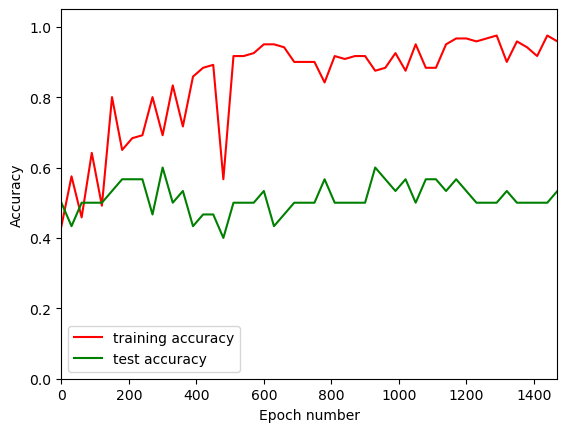

Accuracy: 94.16666666666667 %


Dataset 3


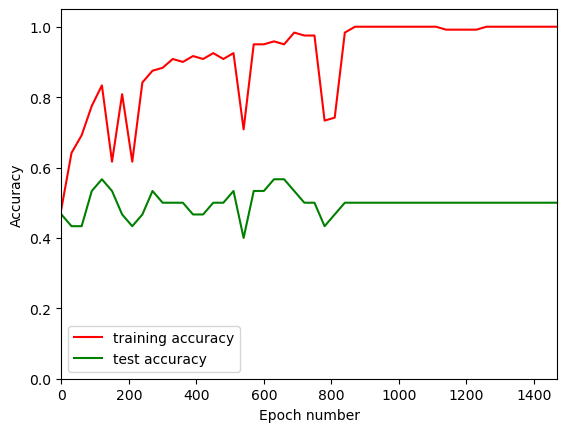

Accuracy: 98.33333333333333 %


Dataset 4


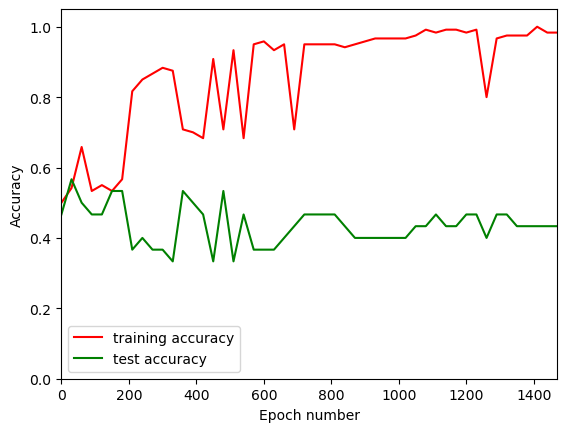

Accuracy: 98.33333333333333 %


In [49]:
n_iterations=1500
lambda_w = 0.0001
D=200
gamma=10000

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    svm = SVM(new_train_data, new_test_data)
    svm.train(1500, 0.0001)
    svm.make_plot()
    svm.print_accuracy()
    ########## END YOUR CODE ############ 

#### Answer 2.4
If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.
We can easily see that from the plots, since we get very high accuracies on the training set, but very low accuracies on the test set. Also, with a very high gamma ,if we look at the decision boundaries of our model, we can see that they are very close to the ones of a 1-NN.